In [ ]:
import  warnings 
warnings.filterwarnings('ignore')

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import confusion_matrix ,classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


In [ ]:

#load data
real=pd.read_csv("/content/drive/My Drive/True.csv")
fake=pd.read_csv("/content/drive/My Drive/Fake.csv")



print(fake.head(1))
print(real.head(1))
print(fake.columns)
print(real.columns)
print(len(fake))
print(len(real))

                                               title  ...               date
0   Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017

[1 rows x 4 columns]
                                               title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 

[1 rows x 4 columns]
Index(['title', 'text', 'subject', 'date'], dtype='object')
Index(['title', 'text', 'subject', 'date'], dtype='object')
23481
21417


In [ ]:
print("real")
#real_news
print(real.title.head(1))
print(real.text.head(1))
print(real.subject.head(1))
#fake news
print("fake")
print(fake.title.head(1))
print(fake.text.head(1))
print(fake.subject.head(1))

real
0    As U.S. budget fight looms, Republicans flip t...
Name: title, dtype: object
0    WASHINGTON (Reuters) - The head of a conservat...
Name: text, dtype: object
0    politicsNews
Name: subject, dtype: object
fake
0     Donald Trump Sends Out Embarrassing New Year’...
Name: title, dtype: object
0    Donald Trump just couldn t wish all Americans ...
Name: text, dtype: object
0    News
Name: subject, dtype: object


In [ ]:
#unknown_publishers in real news
unknown_publishers = []
for index,row in enumerate(real.text.values):
  try:
    record = row.split(" -",maxsplit=1)
    record[1]
    assert(len(record[0])<260)
  except:
    unknown_publishers.append(index)
print(unknown_publishers)   
#print(real.iloc[unknown_publishers].text)  
print(len(unknown_publishers))

[3488, 4358, 4465, 5784, 6660, 6823, 7922, 8194, 8195, 8247, 8465, 8481, 8482, 8505, 8506, 8771, 8970, 9008, 9009, 9307, 9618, 9737, 10479]
23


In [ ]:
#seperating publication info in real news
publisher = []
temp_text = []
for index , row in enumerate(real.text.values):
  if index in unknown_publishers:
    publisher.append("unknown")
    temp_text.append(row)
    continue
  record = row.split(" -",maxsplit=1)  
  publisher.append(record[0])
  temp_text.append(record[1]) 
real['publisher'] = publisher 
real['text'] = temp_text 
print(real.columns) 

Index(['title', 'text', 'subject', 'date', 'publisher'], dtype='object')


In [ ]:
#fake news
print(fake.title.head())
print(fake.text.head())
print(fake.subject.head())

0     Donald Trump Sends Out Embarrassing New Year’...
1     Drunk Bragging Trump Staffer Started Russian ...
2     Sheriff David Clarke Becomes An Internet Joke...
3     Trump Is So Obsessed He Even Has Obama’s Name...
4     Pope Francis Just Called Out Donald Trump Dur...
Name: title, dtype: object
0    Donald Trump just couldn t wish all Americans ...
1    House Intelligence Committee Chairman Devin Nu...
2    On Friday, it was revealed that former Milwauk...
3    On Christmas day, Donald Trump announced that ...
4    Pope Francis used his annual Christmas Day mes...
Name: text, dtype: object
0    News
1    News
2    News
3    News
4    News
Name: subject, dtype: object


In [ ]:
#clean data from null values
empty_real_index_title=[index for index,title in enumerate(real.title.values) if str(title).strip()=='']
empty_fake_index_title=[index for index,title in enumerate(fake.title.values) if str(title).strip()=='']
print(len(empty_real_index_title))
print(len(empty_fake_index_title))


empty_real_index=[index for index,text in enumerate(real.text.values) if str(text).strip()=='']
empty_fake_index=[index for index,text in enumerate(fake.text.values) if str(text).strip()=='']
print(len(empty_real_index))
print(len(empty_fake_index))


empty_real_index_sub=[index for index,text in enumerate(real.subject.values) if str(text).strip()=='']
empty_fake_index_sub=[index for index,text in enumerate(fake.subject.values) if str(text).strip()=='']
print(len(empty_real_index_sub))
print(len(empty_fake_index_sub))

0
0
1
630
0
0


In [ ]:
print(real.text.values[empty_real_index],'before')
real=real.drop(empty_real_index,axis=0)
print(real.text.values[empty_real_index],'after')


#print(fake.text.values[empty_fake_index],'before')
fake=fake.drop(empty_fake_index,axis=0)
#print(fake.text.values[empty_fake_index],'after')

[' '] before
[' The U.S. Supreme Court is set to rule on Monday on a legal challenge by abortion providers to a Texas law requiring doctors performing the procedure to have “admitting privileges” at local hospitals and clinics to meet hospital-grade standards.  Following is a timeline of that challenge. July 2013 - The Republican-led Texas legislature passes and Republican Governor Rick Perry signs the law known as H.B. 2, putting new requirements on abortion providers. State officials say the law is intended to ensure the health and safety of women. September 2013 – Before the law is enforced, Planned Parenthood and other abortion providers challenge the measure. They assert that certain provisions, including one related to doctors’ “admitting privileges” - a type of formal affiliation - at a hospital within 30 miles (48 km) of an abortion clinic, are aimed at decreasing the abortion availability in the state. October 2013 – A U.S. district judge sides largely with the challengers, bl

In [ ]:
#add class info
real['class'] = 1
fake['class'] = 0
#combining title and text
real['text'] = real.title + " " + real.text + " " + real.subject
fake['text'] = fake.title + " " + fake.text + " " + fake.subject
#clean 
real = real.drop(['date','title','publisher','subject'],axis=1)
fake = fake.drop(['date','title','subject'],axis=1)
#combining both into new dataframe
data = pd.concat([real,fake],ignore_index = True)

df = data.sample(frac=1).reset_index(drop=True)
df.head()

,text,class
0,PLANNED PARENTHOOD Draws Outrage After Mother’...,0
1,Senator Delivers SCATHING Rebuke To His GOP C...,0
2,"Japan's Abe: agreed with Trump, Putin on coope...",1
3,Military option must remain on the table with ...,1
4,SEC nominee Clayton vows separation from his W...,1


In [ ]:
#Tokenization & stem
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
  tokens = [word for sentt in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sentt)]
  filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]',token)]
  stem = [stemmer.stem(ftoken) for ftoken in filtered_tokens]
  return stem  

In [ ]:
nltk.download('punkt')
rows = [row for row in df['text']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Create TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english',tokenizer=tokenize_and_stem,max_df=0.8, min_df=0.2,ngram_range=(1,3))
tfidf_m = tfidf_vectorizer.fit_transform(rows)

In [ ]:
X = tfidf_m.toarray()
y = df['class'].values
print(X)
print(y)
print(type(X))
print(type(y))

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.31965908 ... 0.25111743 0.         0.20977939]
 [0.         0.13774948 0.         ... 0.         0.         0.05783975]
 [0.         0.         0.11108489 ... 0.11635459 0.1243239  0.09720072]]
[0 0 1 ... 0 0 1]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
np.save('/content/drive/My Drive/X.npy' , X)
np.save('/content/drive/My Drive/y.npy' , y)

In [ ]:
#split data to test and train
X = np.load('/content/drive/My Drive/X.npy')
y = np.load('/content/drive/My Drive/y.npy')
print('Cells : {} | labels : {}'.format(X.shape , y.shape))
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

Cells : (44267, 74) | labels : (44267,)


In [ ]:
print(len(X_train))
print(len(y_test))

35413
8854


In [ ]:
#LogisticRegression 
LogisticReg = SGDClassifier(loss='log')
LogisticReg.fit(X_train,y_train)
print(LogisticReg.score(X_train,y_train))
print(LogisticReg.score(X_test,y_test))


0.9782565724451473
0.9783148859272646


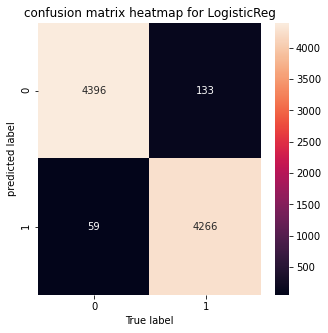

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4529
           1       0.97      0.99      0.98      4325

    accuracy                           0.98      8854
   macro avg       0.98      0.98      0.98      8854
weighted avg       0.98      0.98      0.98      8854



In [ ]:
y_pred2=LogisticReg.predict(X_test)
LogisticReg_confuse = confusion_matrix(y_test,y_pred2)
LogisticReg_confuse_df = pd.DataFrame(LogisticReg_confuse)
plt.figure(figsize=(5,5))
sns.heatmap(LogisticReg_confuse_df,annot=True,fmt='g')
plt.title('confusion matrix heatmap for LogisticReg')
plt.xlabel('True label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(y_test, y_pred2))

In [ ]:

# linsvm
linsvm = SGDClassifier(loss='hinge')
linsvm.fit(X_train,y_train)
print(linsvm.score(X_train,y_train))
print(linsvm.score(X_test,y_test))

0.993307542427922
0.994465778179354


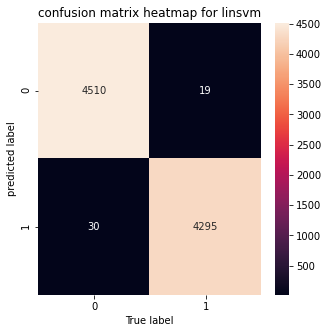

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4529
           1       1.00      0.99      0.99      4325

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854



In [ ]:
y_pred3=linsvm.predict(X_test)
linsvm_confuse = confusion_matrix(y_test,y_pred3)
linsvm_confuse_df = pd.DataFrame(linsvm_confuse)
plt.figure(figsize=(5,5))
sns.heatmap(linsvm_confuse_df,annot=True,fmt='g')
plt.title('confusion matrix heatmap for linsvm')
plt.xlabel('True label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(y_test, y_pred3))

In [ ]:
#Applying GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
print(nb.score(X_train,y_train))
print(nb.score(X_test,y_test))

0.9885635218704996
0.9897221594759431


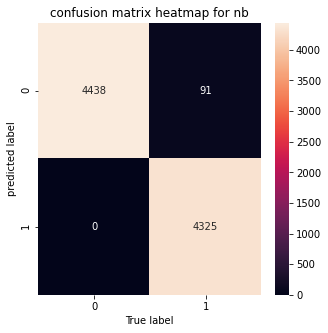

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4529
           1       0.98      1.00      0.99      4325

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854



In [ ]:
y_pred4=nb.predict(X_test)
nb_confuse = confusion_matrix(y_test,y_pred4)
nb_confuse_df = pd.DataFrame(nb_confuse)
plt.figure(figsize=(5,5))
sns.heatmap(nb_confuse_df,annot=True,fmt='g')
plt.title('confusion matrix heatmap for nb')
plt.xlabel('True label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(y_test, y_pred4))

In [ ]:
#random forest
RandomForestClassifierModel = RandomForestClassifier(criterion = 'gini',n_estimators=100,max_depth=2,random_state=33) #criterion can be also : entropy 
RandomForestClassifierModel.fit(X_train, y_train)
print('RandomForestClassifierModel Train Score is : ' , RandomForestClassifierModel.score(X_train, y_train))
print('RandomForestClassifierModel Test Score is : ' , RandomForestClassifierModel.score(X_test, y_test))

RandomForestClassifierModel Train Score is :  0.9742749837630249
RandomForestClassifierModel Test Score is :  0.9726677208041563


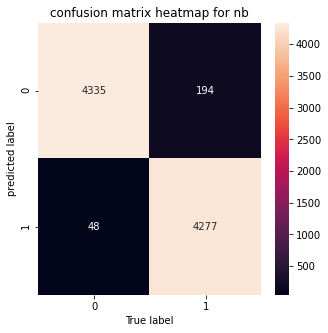

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      4529
           1       0.96      0.99      0.97      4325

    accuracy                           0.97      8854
   macro avg       0.97      0.97      0.97      8854
weighted avg       0.97      0.97      0.97      8854



In [ ]:
y_pred5=RandomForestClassifierModel.predict(X_test)
nb_confuse = confusion_matrix(y_test,y_pred5)
nb_confuse_df = pd.DataFrame(nb_confuse)
plt.figure(figsize=(5,5))
sns.heatmap(nb_confuse_df,annot=True,fmt='g')
plt.title('confusion matrix heatmap for nb')
plt.xlabel('True label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(y_test, y_pred5))

In [ ]:
#Applying MultinomialNB
Mnb = MultinomialNB()
Mnb.fit(X_train, y_train)
print(Mnb.score(X_train,y_train))
print(Mnb.score(X_test,y_test))


0.9484934910908424
0.9491755138920263


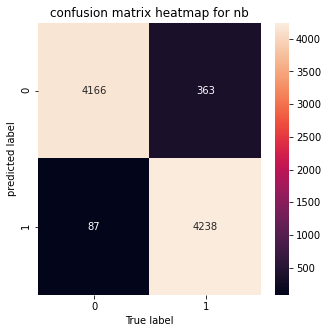

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4529
           1       0.98      1.00      0.99      4325

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854



In [ ]:
y_pred6=Mnb.predict(X_test)
nb_confuse = confusion_matrix(y_test,y_pred6)
nb_confuse_df = pd.DataFrame(nb_confuse)
plt.figure(figsize=(5,5))
sns.heatmap(nb_confuse_df,annot=True,fmt='g')
plt.title('confusion matrix heatmap for nb')
plt.xlabel('True label')
plt.ylabel('predicted label')
plt.show()
print(classification_report(y_test, y_pred4))